In [1]:
import itertools
import random
import re

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, models
import transformers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
VOCABULARY = [str(d) for d in range(10)] + ['+', '=', 'Q', 'E', 'F', '!']
VOCABULARY

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '+',
 '=',
 'Q',
 'E',
 'F',
 '!']

In [3]:
def data(n_samples, max_n_digits, seed, min_n_digits=1):
    random.seed(seed)
    already_generated = set()
    
    while True:
        if len(already_generated) >= n_samples:
            break
        
        n_digits = random.randint(min_n_digits, max_n_digits)
        
        a = random.randint(0, 10 ** n_digits - 1)
        b = random.randint(0, 10 ** n_digits - 1)
        
        if (a, b) in already_generated:
            continue
        
        already_generated.add((a, b))
        
        problem = f'{a:0{n_digits}d}+{b:0{n_digits}d}'

        carry = 0
        
        for significance in range(n_digits):
            a_digit = (a // 10 ** significance) % 10
            b_digit = (b // 10 ** significance) % 10
            result = a_digit + b_digit + carry
            result_digit = result % 10
            result_carry = result // 10
            problem += f'Q{carry}+{a_digit}+{b_digit}E{result_carry}{result_digit}'
            carry = result_carry
        
        problem += f'F{a+b}!'
        
        yield problem

next(data(100, 3, 0))

'97+53Q0+7+3E10Q1+9+5E15F150!'

In [4]:
def tokenize(s):
    s = list(s)
    return np.array([VOCABULARY.index(c) for c in s], dtype=np.int32)

def detokenize(arr):
    return ''.join([VOCABULARY[x] for x in arr])

In [5]:
def system_1(s):
    return f'{eval(s):02d}'

system_1('7+1+0')

'08'

In [6]:
def data_generator(dataset):
    for example in dataset:
        idxs = [(m.start(0), m.end(0))
                for m in re.finditer('Q.\+.\+.E|F.*!', example[1:])]
        
        tokens = tokenize(example)
        inputs = tokens[:-1]
        targets = tokens[1:]
        
        mask = np.array([0] * len(targets))
        for s, e in idxs:
            mask[s:e] = 1
        
        yield inputs, targets, mask

In [35]:
def decode(model, a, b):
    n_digits = max(len(str(a)), len(str(b)))
    ex = f"{a:0{n_digits}d}+{b:0{n_digits}d}"
    tokenized = tokenize(ex).astype(np.int32)
    
    while True:
        while not tokenized[-1] in (VOCABULARY.index('E'), VOCABULARY.index('!')):
            pred = model(tokenized[np.newaxis, ...])
            pred = pred.numpy()
            next_token = np.argmax(pred, axis=-1)[0, -1].astype(np.int32)
            tokenized = np.append(tokenized, next_token)

        if tokenized[-1] == VOCABULARY.index('E'):
            # Call system 1
            query = detokenize(tokenized)[-6:-1]
            ans = system_1(query)
            tokenized_ans = tokenize(ans)
            tokenized = np.append(tokenized, tokenized_ans)

        elif tokenized[-1] == VOCABULARY.index('!'):
            break

    return detokenize(tokenized)

In [18]:
def evaluate(model, test_dataset):
    n_correct = 0
    for example in test_dataset:
        i = example.index('Q')
        ab = example[:i]
        i = ab.index('+')
        a = int(ab[:i])
        b = int(ab[i:])

        try:
            ans = decode(model, a, b)
            i = ans.index('F')
            ans = ans[i+1:-1]
            ans = int(ans)

            if ans == a + b:
                n_correct += 1
        except ValueError as err:
            print("Eval error:", err)

    return n_correct / len(test_dataset)

In [9]:
def build_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [10]:
def build_attention_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    # Attention mechanism.
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x = layers.Concatenate()([x, x_att])
    
    x = layers.Dense(vocab_size, activation='softmax')(x)
    model = models.Model(inputs, x)
    
    return model

In [11]:
def build_copy_model(vocab_size):
    inputs = layers.Input((None,), dtype=tf.int32)
    x = inputs
    x = layers.Embedding(vocab_size, 64)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    
    batch_size = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    keys = layers.Dense(128)(x)
    look_ahead_mask = (1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)) * -1e9
    look_ahead_mask = look_ahead_mask[tf.newaxis, ...]
    attention_scores = x @ tf.transpose(keys, [0, 2, 1])
    attention_scores = attention_scores + look_ahead_mask
    attention_weights = tf.nn.softmax(attention_scores, name="attention_weights")
    x_att = attention_weights @ x
    x = layers.Concatenate()([x, x_att])
    
    # Generative distribution.
    gen_dist = layers.Dense(vocab_size, activation='softmax')(x)
    
    # Copy mechanism based distribution.
    indices = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]  # (bs, 1)
    indices = tf.tile(indices, [1, seq_len])  # (bs, seq_len)
    indices = tf.stack((indices, inputs), axis=2)
    #indices = tf.transpose(indices, perm=[1, 2, 0])  # (bs, seq_len, 2)
    updates = tf.transpose(attention_weights, perm=[0, 2, 1])
    output_shape = [batch_size, vocab_size, seq_len]
    copy_dist = tf.scatter_nd(indices, updates, output_shape)
    copy_dist = tf.transpose(copy_dist, [0, 2, 1])
    
    # Combine distributions.
    p_gen_pre_logit = layers.Concatenate()([x_att, keys])
    p_gen = layers.Dense(1, activation="sigmoid")(p_gen_pre_logit)
    dist = p_gen * gen_dist + (1 - p_gen) * copy_dist 
    
    model = models.Model(inputs, dist)
    
    return model

In [39]:
def run_experiment(train_dataset, test_dataset, model_type):
    tf.keras.backend.clear_session()
    
    vocab_size = len(VOCABULARY)
    if model_type == "baseline":
        model = build_model(vocab_size)
    elif model_type == "attention":
        model = build_attention_model(vocab_size)
    elif model_type == "copy":
        model = build_copy_model(vocab_size)
    else:
        raise Exception("Invalid model.")

    optimizer = optimizers.Adam(1e-3)

    model.build(input_shape=(None, None))
    model.summary()

    train_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(train_dataset),
        output_types=(tf.int32, tf.int32, tf.int32),
        output_shapes=(
            tf.TensorShape((None,)), 
            tf.TensorShape((None,)), 
            tf.TensorShape((None,))
        ))
    train_ds = train_ds.shuffle(10000)
    train_ds = train_ds.padded_batch(64, padded_shapes=([None], [None], [None]))

    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    @tf.function
    def train_step(inputs, targets, mask):
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            loss = tf.losses.sparse_categorical_crossentropy(targets, outputs)
            loss = tf.boolean_mask(loss, tf.cast(mask, tf.bool))
            loss = tf.reduce_mean(loss)

            masked_outputs = tf.boolean_mask(outputs, tf.cast(mask, tf.bool))
            accuracy(targets, outputs, sample_weight=mask)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss

    accuracy_history = []
    stop_criteria_last_n = 3
    
    for i, (inputs, targets, mask) in train_ds.repeat(None).take(4000).enumerate():
        accuracy.reset_states()
        loss = train_step(inputs, targets, mask)
        if i % 100 == 0 and i > 0:
            print(
                'Step', i.numpy(),
                'Loss', loss.numpy(),
                'Acc', accuracy.result().numpy())
            accuracy_history.append(accuracy.result().numpy())
            if len(accuracy_history) > stop_criteria_last_n:
                accuracy_history = accuracy_history[1:]
            if sum(accuracy_history) >= 1.0 * stop_criteria_last_n - 0.001:
                break
    
    accuracy = evaluate(model, test_dataset)
    
    return accuracy, model

## Baseline

In [ ]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    accuracy, _ = run_experiment(train_dataset, test_dataset, model_type="baseline")
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [ ]:
accuracies

## Baseline + self attention

In [ ]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [100, 500, 1000, 2000]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    accuracy, _ = run_experiment(train_dataset, test_dataset, model_type="attention")
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [ ]:
accuracies

## Baseline + self attention + copy mechanism

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(3,)]               0           lstm[0][0]                       
______________________________________________________________________________________________

Step 100 Loss 0.72339 Acc 0.84549356
Step 200 Loss 0.04561225 Acc 0.9955556
Step 300 Loss 0.01249262 Acc 1.0
Step 400 Loss 0.0061105196 Acc 1.0
Step 500 Loss 0.0033457172 Acc 1.0
invalid literal for int() with base 10: '11+0+5E06F60'
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________

Step 100 Loss 0.72325313 Acc 0.8043478
Step 200 Loss 0.099478014 Acc 0.972332
Step 300 Loss 0.012943586 Acc 1.0
Step 400 Loss 0.0104984855 Acc 1.0
Step 500 Loss 0.0045968066 Acc 1.0


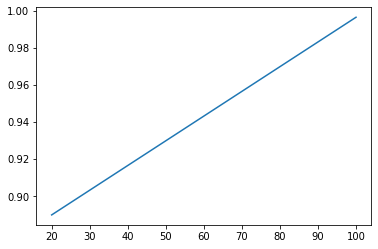

In [17]:
dataset = data(
    n_samples=5000,
    max_n_digits=2,
    seed=0)
dataset = list(dataset)

test_dataset = dataset[-300:]

n_train_sizes = [20, 50, 75, 100]
accuracies = []
for n_train in n_train_sizes:
    train_dataset = dataset[:n_train]
    accuracy, _ = run_experiment(train_dataset, test_dataset, model_type="copy")
    accuracies.append(accuracy)
    
plt.plot(n_train_sizes, accuracies)
plt.show()

In [19]:
accuracies

[0.89, 0.9966666666666667]

## Increasing num digits in training data

In [ ]:
train_dataset = data(
    n_samples=20000,
    max_n_digits=10,
    seed=0)
train_dataset = list(train_dataset)

test_dataset = data(
    n_samples=100,
    max_n_digits=11,
    min_n_digits=11,
    seed=0)
test_dataset = list(test_dataset)

accuracy, model = run_experiment(train_dataset, test_dataset, model_type="copy")
print(accuracy)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 128)    98816       embedding[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Shape_1 (TensorFlow [(3,)]               0           lstm[0][0]                       
______________________________________________________________________________________________

In [ ]:
decode(model, 11111, 22222)

## Model inspection

Softmax output:
tf.Tensor(
[5.4974299e-07 4.5491379e-06 2.3568574e-09 5.8792615e-10 3.0597482e-09
 2.8557656e-09 1.7530151e-09 2.7995368e-09 2.7640148e-09 1.1759320e-08
 5.5896015e-07 2.2194342e-11 9.8302680e-01 1.6953945e-02 1.3359379e-05
 1.6310629e-07], shape=(16,), dtype=float32)
Argmax token: Q
Attention weights:


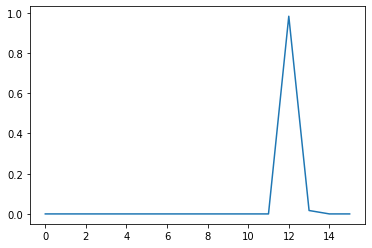

In [28]:
ex = "123+567Q0+3+7E1"
tokenized = tokenize(ex)

model2 = models.Model(
    inputs=model.inputs,
    outputs=[model.outputs, model.get_layer('tf_op_layer_add_1').output])

pred, att_weights = model2(tokenized[np.newaxis, ...])
print("Softmax output:")
print(pred[0][0, -1, :])
print('Argmax token:', VOCABULARY[np.argmax(pred[0][0, -1, :])])

print("Attention weights:")
plt.plot(att_weights[0, -1, :])